In [1]:
import os
import pickle
import numpy as np
from collections import OrderedDict

from scipy.stats import linregress
import matplotlib.pyplot as plt

from openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [31]:
class DataPlotter(object):
    
    def __init__(self, d_labels_to_info):
        
        # Set unsampled state indices
        self.first_unsampled_state_index = 0
        self.last_unsampled_state_index = -1
        
        # Load data
        data = OrderedDict()
        for i, (label, d_info) in enumerate(d_labels_to_info.items()):
            
            file_paths = d_info["file_paths"]
            slice_begs = d_info["slice_begs"]
            slice_ends = d_info["slice_ends"]
            total_iterations = d_info["total_iterations"]
            
            # Load free energy matrices at each time point
            for j, (file_path, slice_beg, slice_end) in enumerate(zip(file_paths, slice_begs, slice_ends)):
                
                if j == 0:
                    with open(file_path, "rb") as f:
                        results = pickle.load(f)
                    data[label] = {"results": results[slice_beg:slice_end]}
                
                else:
                    with open(file_path, "rb") as f:
                        results = pickle.load(f)
                    data[label]["results"] += results[slice_beg:slice_end]
            
            data[label]["total_iterations"] = total_iterations
                
        self.data = data
        
        # Set colors
        self.colors = ["#80b1d3", "#fdb462", "#b3de69"]
        
    def _generate_free_energy_summary_plot(self, 
                              phase,
                              override_title=None, 
                              show_legend=False,
                              legend_loc=None,
                              y_axis_min=None, 
                              y_axis_max=None, 
                              include_phase_in_label=False,
                              save_path=None):
        
        n_mutations = len(self.data.keys())
        
        # Assemble data
        mutations = []
        slopes = []
        errors = []
        
        for i, (label, data) in enumerate(self.data.items()):

            # Retrieve info from label
            title = label.split("(")[0][:-1]
            mutation = title.split(" ")[0]
            mutations.append(mutation)
            
            # Retrieve x values (time points)
            x = np.array(range(1000, data["total_iterations"] + 1, 1000)) / 1000

            # Retrieve y values (free energies in kcal/mol)
            dgs = np.array([t["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results"]])
            ddgs = np.array([t["dDeltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results"]])
            
            # Compute slope
            slope, intercept, r, p, se = linregress(x[-5:], dgs[-5:])
            slopes.append(slope)
            errors.append(se)
            
            print(mutation, slope, 2*se)

        # Set figure size
        fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(16, 4))

        # Set font size
        plt.rc('font', size=15) 
        
        # Plot area within cutoff of 0
        cutoff = 0.1
        axes.axhline(y=0, linestyle='solid', linewidth=2, color='gray', label=r'Slope = 0')
        axes.fill_between(range(-1, n_mutations + 1), [-cutoff]*(n_mutations + 2), [cutoff]*(n_mutations + 2), alpha=0.15, label= f"Slope = 0 +/- {cutoff}", color='gray')
        
        # Plot
        errors = np.array(errors)
        plt.scatter(mutations, slopes, s=50)
        plt.errorbar(mutations, slopes, yerr=2*errors, fmt='none')
        
        # Set labels
        units = r"$\frac{kcal}{mol \cdot ns}$"
        if include_phase_in_label:
            DG = r"$\Delta G_\mathrm{{{0}}}$".format(phase)
            axes.set_ylabel(f"{DG} slope ({units})")
        else:
            axes.set_ylabel(f"Slope ({units})")
        axes.set_xlabel("Mutation")
        plt.xticks(rotation=45, ha='right')
        
        # Set y limit 
        if y_axis_min and y_axis_max:
            plt.yticks(np.arange(y_axis_min, y_axis_max, 0.1))
        
        # Set x limit
        plt.xlim([-1, n_mutations])

        # Set title
        if override_title:
            axes.set_title(override_title)
        else:
            axes.set_title(title)
            
        # Show legend
        if show_legend:
            legend_loc = legend_loc if legend_loc else 'best'
            plt.legend(loc=legend_loc)

        # Ensure x-axis labels are not cut off
        plt.tight_layout()

        # Save plot as pdf
        if save_path:
            plt.savefig(save_path, dpi=500)
            plt.show()
            plt.clf()
        else:
            plt.show()

# Barnase:barstar

### Complex 10 ns (AREX)

Y29F 0.029463461951706904 0.02159667322204072
Y29A 0.021977184957858144 0.030395943509635114
W38F 0.01788330686617695 0.01807321759102567
T42A -0.051866923272390154 0.04064232169430834
W44F 0.022974808445767193 0.012217245811436121
E76A 0.05648031508523519 0.01504418926910458
E80A 0.0013324078052460388 0.007948629613416663
D35A -0.033984001165079956 0.043071551491618065
D39A -0.05190836677647122 0.03395381156360214
K27A -0.04323663412516013 0.02040010967060886
R59A 0.043401164153486604 0.013915094081907432
R83Q -0.16379784629858102 0.0281993595921737
R87A -0.44446210857259416 0.034281895110197406
H102A -0.12914185586308308 0.027670837764588625
F29Y -0.01947088733268352 0.017864537106826762
A29Y 0.0018775215550522974 0.017759371821317812
F38W 0.018199722832422414 0.017728271024353554
A42T -0.13177268034895243 0.026105078870238427
F44W 9.974534217284116e-05 0.01735257373476135
A76E -0.03515750857609987 0.013904651426554908
A80E 0.005853326911025647 0.011628945560930665
A35D -0.1166568980

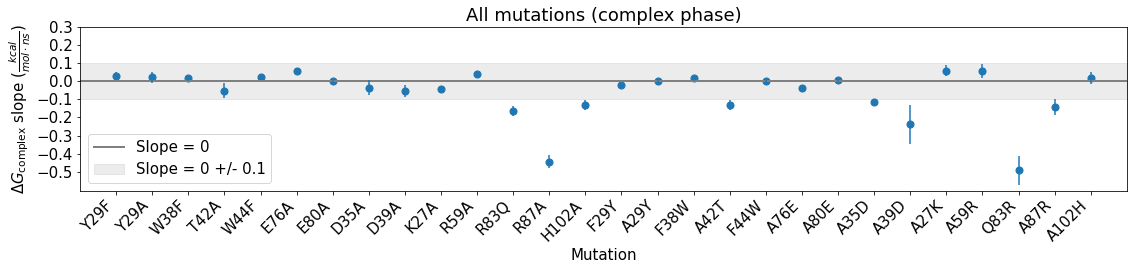

<Figure size 432x288 with 0 Axes>

In [33]:
main_dir_other = 45
main_dir = 47
phase = 'complex'
mutations = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]
d_labels_to_info = OrderedDict({})

for i, sub_dir in enumerate(range(28)):
    if sub_dir == 4:
        replicate = 0
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 11
    elif sub_dir == 12:
        replicate = 1
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 10
    elif sub_dir == 17:
        replicate = 1
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 9
    else:
        replicate = 1
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
    
    filename = f"{phase}_free_energy_timeseries_1_50ns.pickle"
    d_labels_to_info[f"{mutations[i]} complex (no rest r0)"] = {"file_paths": [os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", filename)],
                                                           "slice_begs": [0],
                                                           "slice_ends": [10],
                                                           "total_iterations": 10000,
                                                          }

base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
save_path = os.path.join(base_path, f"{phase}_free_energy_summary_10ns.pdf")
title = r"All mutations (complex phase)"
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_summary_plot(phase,
                                                override_title=title,
                                                show_legend=True,
                                                legend_loc='lower left',
                                                 y_axis_min=-0.5,
                                                 y_axis_max=0.4,
                                                include_phase_in_label=True,
                                                 save_path=save_path)


### Complex 50 ns (AREX)

Y29F 0.0014371590005143988 0.003025347462899219
Y29A -0.010242806621900158 0.007390098187887257
W38F 0.003702516081320395 0.002974621712358305
T42A 0.010616839697595993 0.00602268384472138
W44F 0.00023286518619117236 0.002304072224738965
E76A -0.004274040641512511 0.0029008552824248
E80A 0.002297699073248838 0.0030733744727006332
D35A 0.0004890634812110273 0.001651904912264861
D39A -0.03161241246517479 0.006156279735546283
K27A -0.007790211984914208 0.002465466195493135
R59A 0.004944280002196422 0.001986381563612776
R83Q -0.02789370214493765 0.003953870866678206
R87A -0.031417773102758416 0.0054616480312153735
H102A -0.03152789131825067 0.0005870213906686421
F29Y 0.0059553784306071835 0.004379357491979576
A29Y 0.0009116335641298434 0.0031576624464588377
F38W 0.00852899284250147 0.004662162138675277
A42T -0.023734788141931775 0.004464112601034941
F44W -5.2131243806052833e-05 0.003699807362937845
A76E 0.007053261578465708 0.003150001307132704
A80E 0.010721432725574687 0.00103205285796768

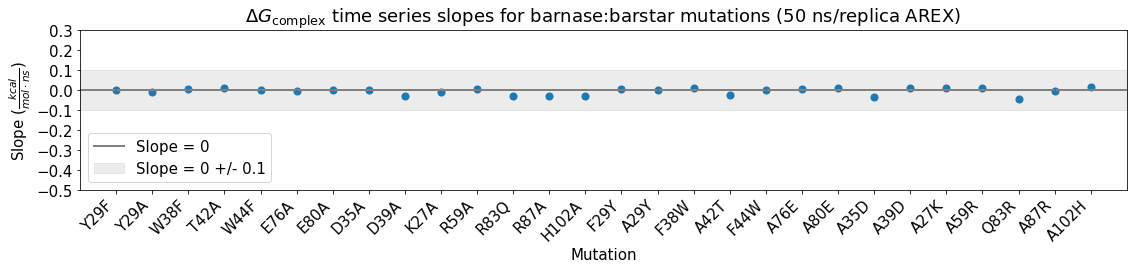

<Figure size 432x288 with 0 Axes>

In [34]:
main_dir_other = 45
main_dir = 47
phase = 'complex'
mutations = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]
d_labels_to_info = OrderedDict({})

for i, sub_dir in enumerate(range(28)):
    filename = f"{phase}_free_energy_timeseries_1_50ns.pickle"
    
    if sub_dir == 4:
        replicate = 0
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 11
        
    elif sub_dir == 12:
        replicate = 1
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 10
        
    elif sub_dir == 17:
        replicate = 1
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 9

    else:
        replicate = 1
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
        
    filename = f"{phase}_free_energy_timeseries_1_50ns.pickle"
    d_labels_to_info[f"{mutations[i]} complex (no rest r0)"] = {"file_paths": [os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", filename)],
                                                           "slice_begs": [0],
                                                           "slice_ends": [50],
                                                           "total_iterations": 50000,
                                                          }

base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
save_path = os.path.join(base_path, f"{phase}_free_energy_summary_50ns.pdf")
title = r"$\Delta G_\mathrm{complex}$ time series slopes for barnase:barstar mutations (50 ns/replica AREX)"
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_summary_plot(phase,
                                                override_title=title,
                                                show_legend=True,
                                                legend_loc='lower left',
                                                 y_axis_min=-0.5,
                                                 y_axis_max=0.4,
                                                 save_path=save_path)


### Complex 50 ns (AREST)

Y29F -0.010831957121539304 0.00343432749480487
Y29A -0.001281971538830007 0.0005060795655751167
W38F 0.014690198965815894 0.008771451132554904
T42A 0.0010749365258725164 0.009272699079585108
W44F 0.03767911278803171 0.014346645812290303
E76A 0.00719828955962617 0.006475885104455516
E80A -0.0055754497839966 0.0025179481797089616
D35A -0.018373194943012604 0.0034037442388053464
D39A -0.006169715529777431 0.0097058409371174
K27A -0.013177904903751881 0.002990601850588952
R59A 0.006206069651875624 0.0076787199912163664
R83Q 0.021468717916327054 0.006279471955866863
R87A -0.05206400421553781 0.008545498592771249
H102A -0.029462292096445 0.006231137672760103
F29Y 0.011124535696636073 0.006231449238920026
A29Y 0.0018497732824965141 0.010220416493425758
F38W -0.016504382181689158 0.007855196335124517
A42T -0.0027807510398133676 0.010409552093432148
F44W -0.009265699626203388 0.004959049227833348
A76E 0.005567419037365085 0.005994956685265109
A80E 0.012496274445180689 0.0015679670906662015
A35D

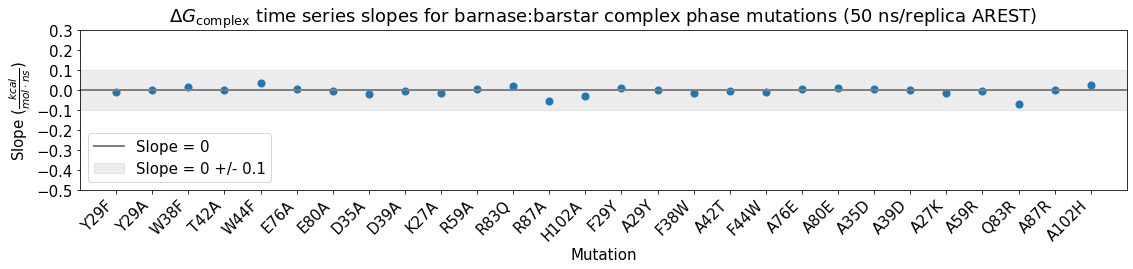

<Figure size 432x288 with 0 Axes>

In [5]:
main_dir = 52
phase = 'complex'
mutations = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]
d_labels_to_info = OrderedDict({})

for i, sub_dir in enumerate(range(28)):
    if sub_dir in [19, 21]:
        replicate = 1
    elif sub_dir in [12, 17]:
        replicate = 0
    else:
        replicate = 0
        
    filename = f"{phase}_free_energy_timeseries_1_50ns.pickle"
    base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
    d_labels_to_info[f"{mutations[i]} complex (no rest r0)"] = {"file_paths": [os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", filename)],
                                                           "slice_begs": [0],
                                                           "slice_ends": [50],
                                                           "total_iterations": 50000,
                                                          }

base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
save_path = os.path.join(base_path, f"{phase}_free_energy_summary_50ns.pdf")
title = r"$\Delta G_\mathrm{complex}$ time series slopes for barnase:barstar complex phase mutations (50 ns/replica AREST)"
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_summary_plot(override_title=title,
                                                show_legend=True,
                                                legend_loc='lower left',
                                                 y_axis_min=-0.5,
                                                 y_axis_max=0.4,
                                                 save_path=save_path)


### Apo 10 ns (AREX)

Y29F 0.027032545111600827 0.02565721092285188
Y29A 0.0009010890086486256 0.01645057909899042
W38F -0.027067884524251153 0.026312238486117242
T42A 0.0027895239188119093 0.021439664793120677
W44F -0.005005093199310745 0.02210034379496823
E76A -0.005299544478095841 0.01114764416817724
E80A 0.014225427026680483 0.02285559948168933
D35A -0.022790239697398462 0.013545129117952845
D39A -0.01126117625090608 0.011859637701874554
K27A 0.03806701532442247 0.015472947691585684
R59A 0.02737148429532539 0.005294208739527354
R83Q 0.021244774875703244 0.028847174767533883
R87A -0.07970086331923341 0.030507328560184413
H102A -0.016284613890450574 0.012976272461227506
F29Y -0.0011622309344758719 0.013503376826679082
A29Y 0.002569904764468234 0.008815054575876455
F38W 0.04516368350672753 0.04596046291819433
A42T -0.022562286791168874 0.013504318209785898
F44W 0.05566360742913512 0.051953799005036626
A76E -0.01656040547729276 0.017143997288600988
A80E -0.0004066435990523587 0.0093136121782512
A35D -0.0386

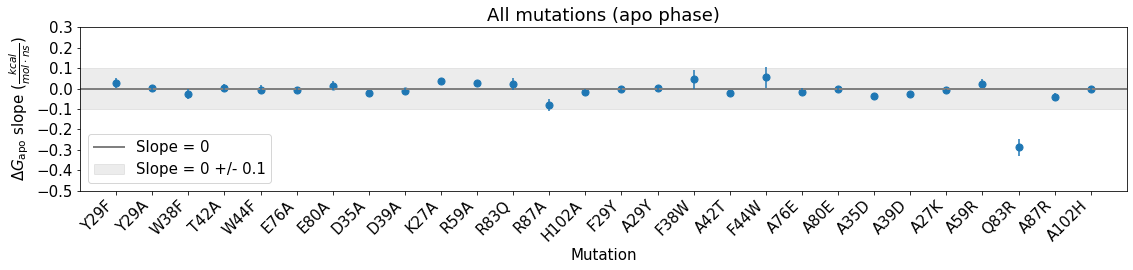

<Figure size 432x288 with 0 Axes>

In [35]:
main_dir_other = 45
main_dir = 47
phase = 'apo'
replicate = 0
mutations = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]
d_labels_to_info = OrderedDict({})

for i, sub_dir in enumerate(range(28)):
    if sub_dir == 4:
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 11
        replicate = 0
    elif sub_dir == 12:
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 10
        replicate = 1
    elif sub_dir == 17:
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_other}/"
        sub_dir = 9
        replicate = 1
    else:
        base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
        replicate = 1
    
    filename = f"{phase}_free_energy_timeseries_1_10ns.pickle"
    d_labels_to_info[f"{mutations[i]} apo (no rest r0)"] = {"file_paths": [os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", filename)],
                                                           "slice_begs": [0],
                                                           "slice_ends": [10],
                                                           "total_iterations": 10000,
                                                          }

base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
save_path = os.path.join(base_path, f"{phase}_free_energy_summary_10ns.pdf")
title = "All mutations (apo phase)"
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_summary_plot(phase,
                                                override_title=title,
                                                show_legend=True,
                                                legend_loc='lower left',
                                                 y_axis_min=-0.5,
                                                 y_axis_max=0.4,
                                                include_phase_in_label=True,
                                                 save_path=save_path)


# Dipeptide

### ACE-X-NME (5 ns AREX)

Y2F 0.06386648922861014 0.0428774149264121
Y2A 0.027669489205200293 0.022654358823465528
W2F -0.05564058727293313 0.10105123607037353
T2A 0.06616419516121219 0.07979942610490193
E2A 0.11423465835657876 0.051765153443142545
D2A 0.018938979901519073 0.027316212459483513
K2A 0.04079934627989701 0.03893535832734675
R2A 0.08547099360275895 0.10682426970562185
R2Q 0.007790367612823346 0.016624544713190224
H2A 0.02865676501743977 0.03521478206875921
F2Y 0.011955793304047902 0.06619431154505136
A2Y -0.00905137797067077 0.03268964333871657
F2W -0.010824640674055197 0.04374614467498811
A2T 0.019441357167351115 0.001521778659725666
A2E -0.03180578730714103 0.03753075450534252
A2D -0.06569442743548848 0.03493599391104544
A2K 0.08447830732956448 0.07277193728147897
A2R 0.12229083730796902 0.12169068390138353
Q2R -0.06961973821619552 0.09319123373053399
A2H -0.059112283011970135 0.06585821640611948


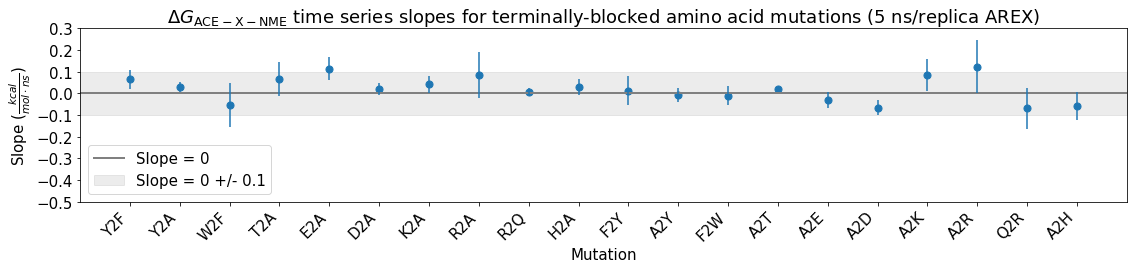

<Figure size 432x288 with 0 Axes>

In [10]:
main_dir = 46
phase = 'apo'
replicate = 0
mutations = ["Y2F", "Y2A", "W2F", "T2A", "E2A", "D2A", "K2A", "R2A", "R2Q", "H2A", "F2Y", "A2Y", "F2W", "A2T", "A2E", "A2D", "A2K", "A2R", "Q2R", "A2H"]
d_labels_to_info = OrderedDict({})

for i, sub_dir in enumerate(range(20)):

    filename = f"{phase}_free_energy_timeseries_1_5ns.pickle"
    base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
    
    d_labels_to_info[f"{mutations[i]} apo (no rest r0)"] = {"file_paths": [os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", filename)],
                                                           "slice_begs": [0],
                                                           "slice_ends": [5],
                                                           "total_iterations": 5000,
                                                          }

base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
save_path = os.path.join(base_path, f"{phase}_ACE_NME_free_energy_summary_5ns.pdf")
title = r"$\Delta G_\mathrm{ACE-X-NME}$ time series slopes for terminally-blocked amino acid mutations (5 ns/replica AREX)"
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_summary_plot(override_title=title,
                                                show_legend=True,
                                                legend_loc='lower left',
                                                 y_axis_min=-0.5,
                                                 y_axis_max=0.4,
                                                 save_path=save_path)


### ALA-X-ALA (5 ns AREX)

Y2F 0.14109384970532765 0.07772119071755623
Y2A 0.03978602933587077 0.06508626130676837
W2F -0.14275383340390202 0.06213900322885585
T2A 0.029678664517258826 0.04539753710609418
E2A 0.04689435180542363 0.094753051946661
D2A -0.1315720238719775 0.09675407596412473
K2A -0.010283374026367654 0.0751580779669427
R2A 0.06730346688207334 0.0360035670176335
R2Q -0.05724304054969345 0.08914360416946349
H2A -0.05059295366443842 0.08811156674474736
F2Y 0.025932852857528846 0.017172143540056594
A2Y 0.0108415947847476 0.028815018652017757
F2W -0.1355900169797437 0.16919763143543573
A2T 0.06326705802339916 0.0299272577349586
A2E -0.07015314928575549 0.028454835833628705
A2D -0.04760851732996514 0.06284926716191147
A2K -0.04439727421055722 0.0581855018720876
A2R -0.000931154494509201 0.03150041037633579
Q2R 0.101567920715749 0.08310442938087448
A2H 0.02859660197885923 0.02543982086730493


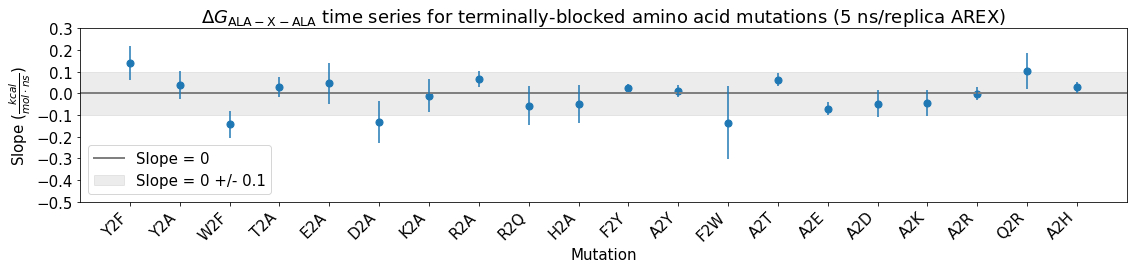

<Figure size 432x288 with 0 Axes>

In [11]:
main_dir = 46
phase = 'apo'
replicate = 0
mutations = ["Y2F", "Y2A", "W2F", "T2A", "E2A", "D2A", "K2A", "R2A", "R2Q", "H2A", "F2Y", "A2Y", "F2W", "A2T", "A2E", "A2D", "A2K", "A2R", "Q2R", "A2H"]
d_labels_to_info = OrderedDict({})

for i, sub_dir in enumerate(range(20, 40)):

    filename = f"{phase}_free_energy_timeseries_1_5ns.pickle"
    base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
    
    d_labels_to_info[f"{mutations[i]} apo (no rest r0)"] = {"file_paths": [os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", filename)],
                                                           "slice_begs": [0],
                                                           "slice_ends": [5],
                                                           "total_iterations": 5000,
                                                          }

base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
save_path = os.path.join(base_path, f"{phase}_ALA_free_energy_summary_5ns.pdf")
title = r"$\Delta G_\mathrm{ALA-X-ALA}$ time series for terminally-blocked amino acid mutations (5 ns/replica AREX)"
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_summary_plot(override_title=title,
                                                show_legend=True,
                                                legend_loc='lower left',
                                                 y_axis_min=-0.5,
                                                 y_axis_max=0.4,
                                                 save_path=save_path)
